<a href="https://colab.research.google.com/github/AMIT110409/Machine-learning-for-user-classifcation-project-/blob/main/Machine_Learning_for_USer_classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Preprocessing

### Importing the Database

In [2]:
raw_data =pd.read_csv("ml_datasource.csv")
raw_data.head()

data = raw_data.copy()

### Removing Outliers

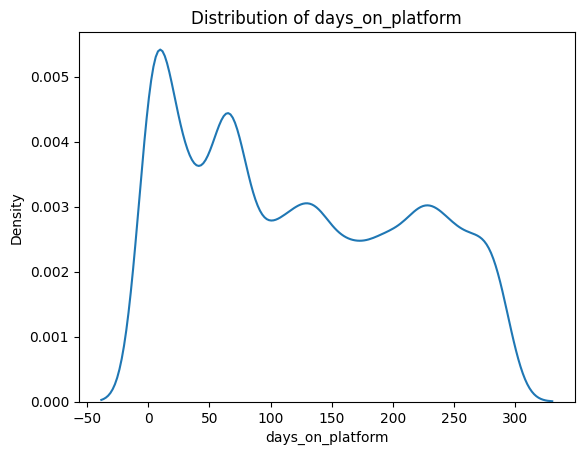

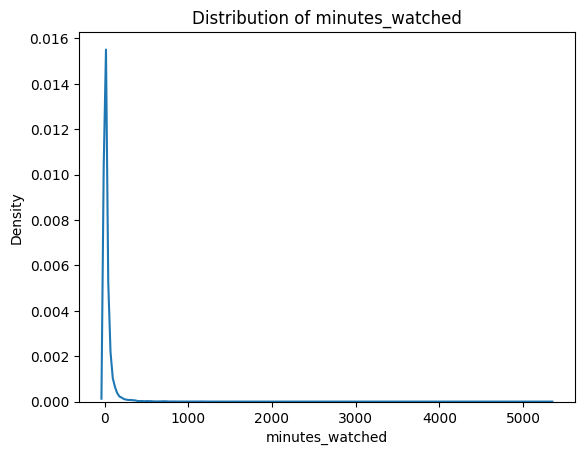

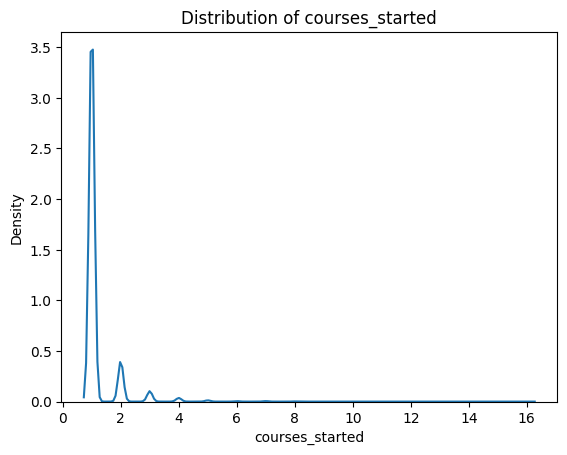

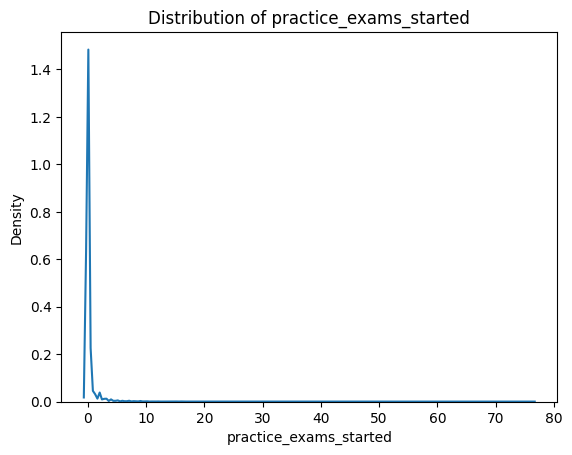

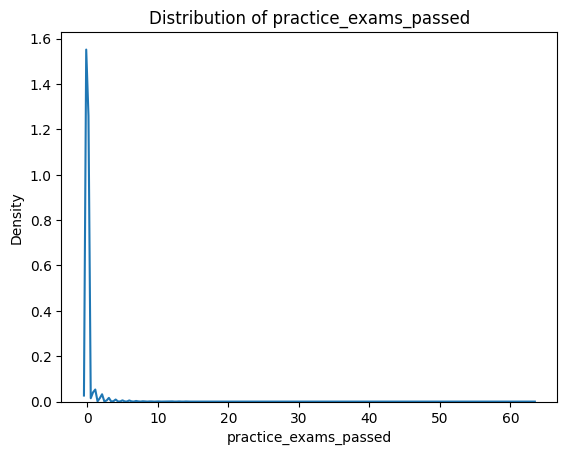

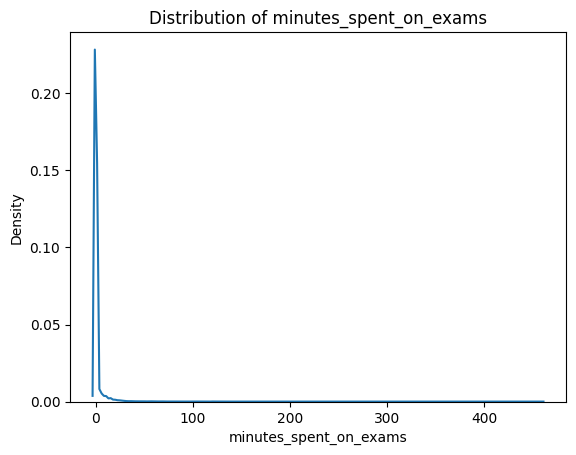

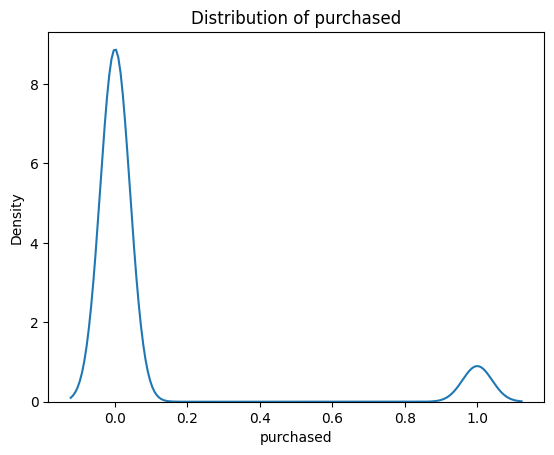

In [3]:
## examine distribution of numerical features

# Examine distribution of numerical features
numerical_cols = [col for col in data.columns if data[col].dtype != object]
for col in numerical_cols:
    sns.kdeplot(data=data, x=col)
    plt.title(f"Distribution of {col}")
    plt.show()


# Remove outliers (adjust thresholds as needed)
data = data[
    (data["minutes_watched"] <= 1000)
    & (data["courses_started"] <= 10)
    & (data["practice_exams_started"] <= 10)
    & (data["minutes_spent_on_exams"] <= 40)
]


### Checking for Multicollinearity

In [4]:
# # Check for multicollinearity
# Get numerical columns directly from DataFrame
numerical_cols = data.select_dtypes(include=[np.number]).columns

# Calculate VIF
vif = pd.DataFrame()
vif["feature"] = numerical_cols
vif["VIF"] = [variance_inflation_factor(data[numerical_cols].values, i) for i in range(len(numerical_cols))]

print(vif)

                  feature        VIF
0        days_on_platform   2.494163
1         minutes_watched   1.814420
2         courses_started   3.504408
3  practice_exams_started  10.206234
4   practice_exams_passed   7.829732
5  minutes_spent_on_exams   3.355225
6               purchased   1.229006


In [6]:
# Iteratively remove features with VIF > 5
while vif["VIF"].max() > 5:
    max_vif_feature = vif.loc[vif["VIF"].idxmax(), "feature"]
    data = data.drop(max_vif_feature, axis=1)
    vif = pd.DataFrame()
    vif["feature"] = data.select_dtypes(include=[np.number]).columns
    vif["VIF"] = [variance_inflation_factor(data[vif["feature"]].values, i) for i in range(len(vif["feature"]))]

print(vif)

                  feature       VIF
0        days_on_platform  2.492125
1         minutes_watched  1.813759
2         courses_started  3.498304
3   practice_exams_passed  2.569373
4  minutes_spent_on_exams  2.616566
5               purchased  1.228475


### Dealing with NaN Values

In [9]:
# Handle NaN values in "student_country"
data_no_nulls = data.fillna({"student_country": "NAM"})  # Replace NaN with "NAM"


In [8]:
null_count = data['student_country'].isnull().sum()
print(null_count)

8


### Splitting the Data

In [10]:
# Split data into targets and inputs
targets = data_no_nulls["purchased"]
inputs = data_no_nulls.drop("purchased", axis=1)

# Split data into training and testing sets (stratified split on target variable)
x_train, x_test, y_train, y_test = train_test_split(
    inputs, targets, test_size=0.2, random_state=365, stratify=targets
)


In [14]:
rows = x_test.shape[0]
print(rows)

3526


### Encoding the Data

In [11]:
# Encode categorical data (student_country)
enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=365)
x_train["student_country_enc"] = enc.fit_transform(x_train["student_country"].to_numpy().reshape(-1, 1))
x_test["student_country_enc"] = enc.transform(x_test["student_country"].to_numpy().reshape(-1, 1))
x_train = x_train.drop("student_country", axis=1)
x_test = x_test.drop("student_country", axis=1)

# Convert to NumPy arrays (optional, but recommended for compatibility)
x_train_array = np.asarray(x_train, dtype="float")
y_train_array = np.asarray(y_train, dtype="int")
x_test_array = np.asarray(x_test, dtype="float")
y_test_array = np.asarray(y_test, dtype="int")

# Now you have preprocessed data ready for machine learning!

cm# Creating a Logistic Regression Model

Optimization terminated successfully.
         Current function value: 0.153146
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                14100
Model:                          Logit   Df Residuals:                    14094
Method:                           MLE   Df Model:                            5
Date:                Mon, 22 Jul 2024   Pseudo R-squ.:                  0.5019
Time:                        10:27:57   Log-Likelihood:                -2159.4
converged:                       True   LL-Null:                       -4334.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0691      0.002    -31.914      0.000      -0.073      -0.065
x2             0.0144      0

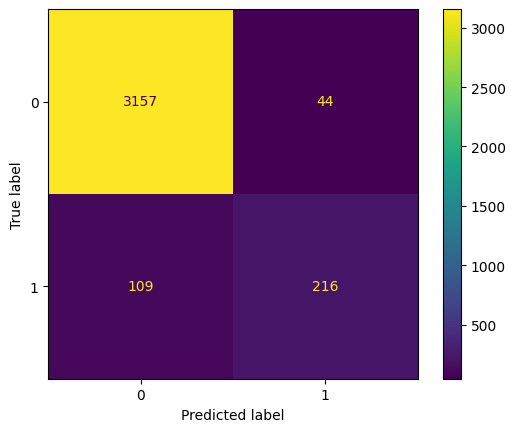

In [12]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create the logistic regression model
log_reg = sm.Logit(y_train_array, x_train_array)

# Fit the model
log_reg_results = log_reg.fit()

# Print the model summary
print(log_reg_results.summary())

# Make predictions on the test data
y_pred_prob = log_reg_results.predict(x_test_array)
y_pred = (y_pred_prob > 0.5).astype(int)

# Create and display the confusion matrix
cm = confusion_matrix(y_test_array, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Creating a K-Nearest Neighbors Model

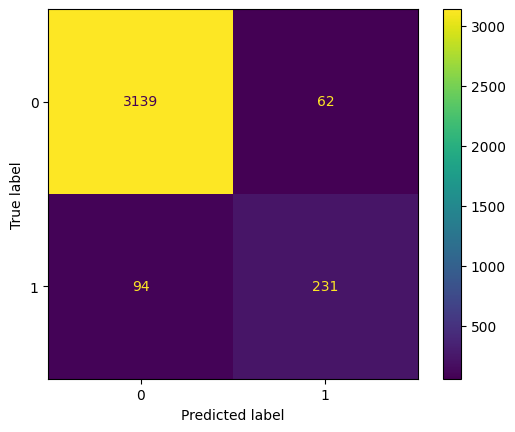

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# define the parameter grid for knn
parameters_knn = {'n_neighbors': list(range(1,51)),'weights':['uniform','distance']}


## create a knn classifier
knn_clf = KNeighborsClassifier()

# create a grid search object

grid_search_knn = GridSearchCV(knn_clf,parameters_knn,scoring = 'accuracy')

# fit the grid search to the training data
grid_search_knn.fit(x_train_array,y_train_array)

## get the best estimator
knn_clf = grid_search_knn.best_estimator_

# print(grid_search_knn.summary())


## make prediction on test data
y_test_pred_knn = knn_clf.predict(x_test_array)

# create and dispaly the confusion matrix

cm_knn = confusion_matrix(y_test_array,y_test_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix =cm_knn)
disp.plot()
plt.show()


In [17]:
# Get the best parameters
best_params = grid_search_knn.best_params_
print("Best parameters:", best_params)

# Get the best cross-validated accuracy score
best_score = grid_search_knn.best_score_
print("Best cross-validated accuracy:", best_score)

Best parameters: {'n_neighbors': 10, 'weights': 'distance'}
Best cross-validated accuracy: 0.9598581560283688


In [18]:
# Check data types
print("x_train_array data types:", x_train_array.dtype)
print("y_train_array data types:", y_train_array.dtype)

# Check shapes
print("x_train_array shape:", x_train_array.shape)
print("y_train_array shape:", y_train_array.shape)

# Check for missing values
print("Missing values in x_train_array:", np.isnan(x_train_array).sum())
print("Missing values in y_train_array:", np.isnan(y_train_array).sum())

# Example: Handling missing values with imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Choose an appropriate strategy
x_train_array = imputer.fit_transform(x_train_array)

# Re-attempt fitting the model
# grid_search_knn.fit(x_train_array, y_train_array)

x_train_array data types: float64
y_train_array data types: int64
x_train_array shape: (14100, 6)
y_train_array shape: (14100,)
Missing values in x_train_array: 0
Missing values in y_train_array: 0


# Creating a Support Vector Machines Model

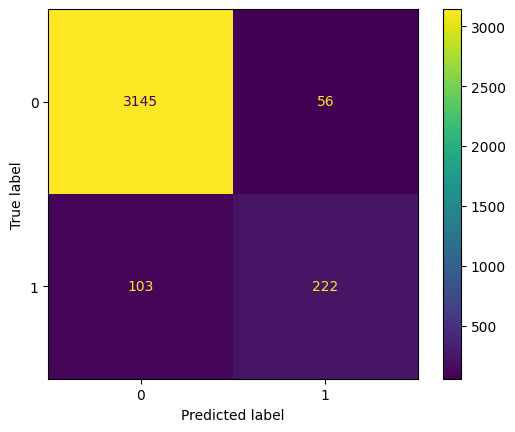

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

##scale the data

scaler = MinMaxScaler(feature_range=(-1,1))
x_train_scaled = scaler.fit_transform(x_train_array)
x_test_scaled = scaler.transform(x_test_array)


# define the parameter grid for svm

parameter_svm = {'kernel':['linear','poly','rbf'] ,'C':[i for i in range(1,11)], 'gamma':['scale','auto']}

#create an svm classifier
svm_clf = SVC()

#Create a grid search object
grid_search_svm = GridSearchCV(svm_clf,parameter_svm,scoring = 'accuracy')

#fir the grid search for training data

grid_search_svm.fit(x_train_scaled,y_train_array)

#get the best estimator
svm_clf = grid_search_svm.best_estimator_

#make prediction on test data
y_test_pred_svm = svm_clf.predict(x_test_scaled)

#create and dispaly the confusion matrix

cm_svm = confusion_matrix(y_test_array,y_test_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_svm)
disp.plot()
plt.show()



# Creating a Decision Trees Model

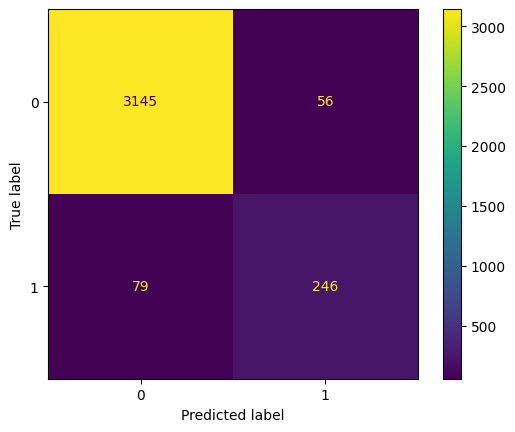

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3201
           1       0.81      0.76      0.78       325

    accuracy                           0.96      3526
   macro avg       0.90      0.87      0.88      3526
weighted avg       0.96      0.96      0.96      3526



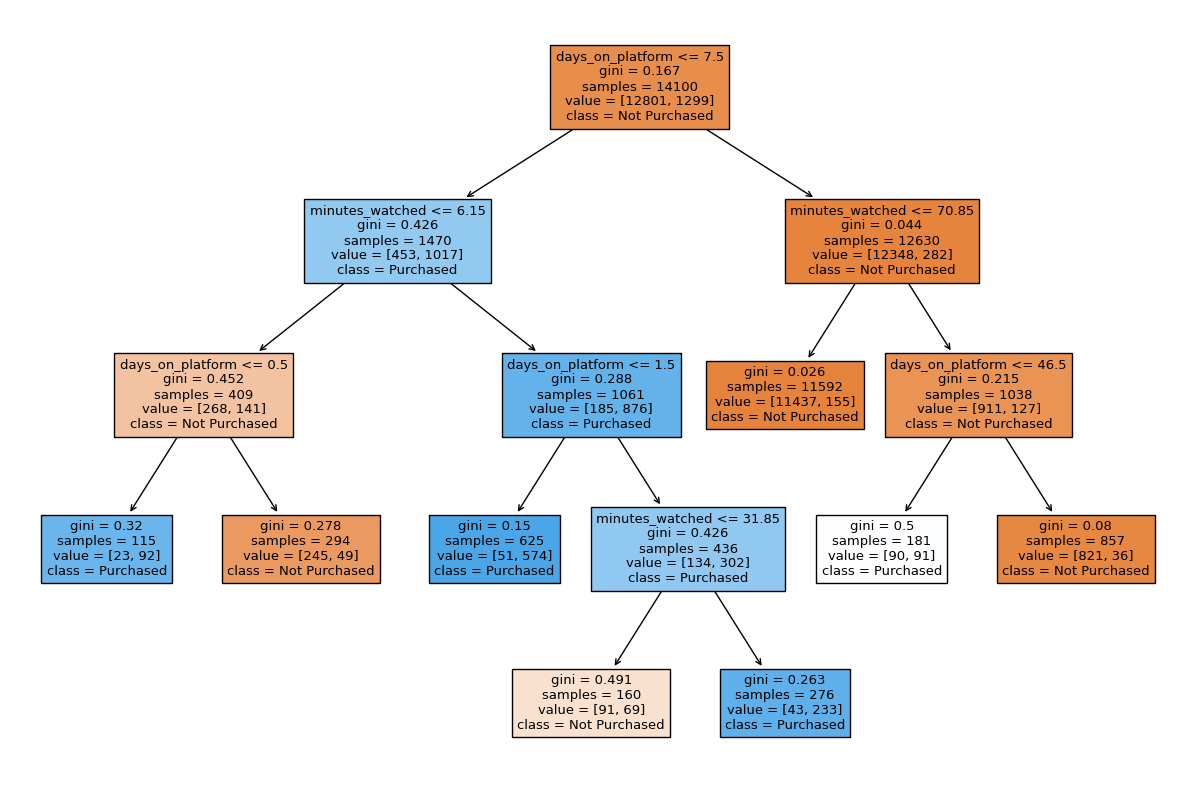

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

##define the parameter grid for decision tree
parameter_dt = {'ccp_alpha':[0,0.001,0.002,0.003,0.004,0.005]}

#rcreate a decision tree classifier
dt_clf = DecisionTreeClassifier(random_state=365)

#create a grid search object

grid_search_dt = GridSearchCV(dt_clf,parameter_dt,scoring = 'accuracy')

#fit the grid search object  to training data
grid_search_dt.fit(x_train_array,y_train_array)

#get the best estimator
dt_clf = grid_search_dt.best_estimator_

# make predication on test data

y_test_pred_dt = dt_clf.predict(x_test_array)

# create and display the confusion matrix display .
cm_dt = confusion_matrix(y_test_array,y_test_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_dt)
disp.plot()
plt.show()

# print the classification report .

print(classification_report(y_test_array,y_test_pred_dt))

#visualize the decision tree

plt.figure(figsize=(15,10))
plot_tree(dt_clf,filled=True,feature_names=list(x_train.columns),class_names = ["Not Purchased","Purchased"])
plt.show()





In [27]:
# Get the best parameters for SVM
best_params_svm=grid_search_svm.best_params_
print("Best parameters for SVM:",best_params_svm)

# Get the best cross-validated accuracy score for SVM
best_score_svm = grid_search_svm.best_score_
print("Best cross-validated accuracy for SVM:",best_score_svm)

Best parameters for SVM: {'C': 8, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validated accuracy for SVM: 0.9607092198581562


# Creating a Random Forests Model

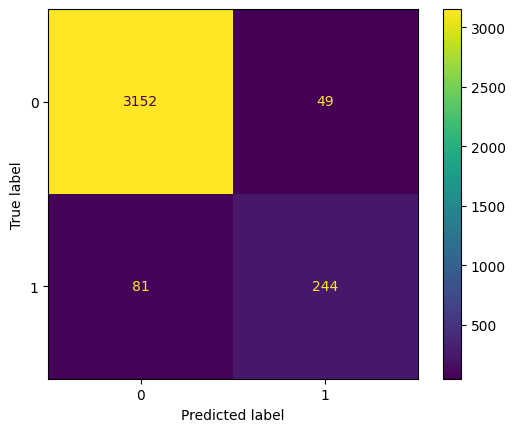

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3201
           1       0.83      0.75      0.79       325

    accuracy                           0.96      3526
   macro avg       0.90      0.87      0.88      3526
weighted avg       0.96      0.96      0.96      3526



In [24]:
from sklearn.ensemble import RandomForestClassifier

## Assuming  you have best_ccp_alpha
best_ccp_alpha = 0.001

# create a random Forest classifier
rf_clf = RandomForestClassifier(ccp_alpha=best_ccp_alpha,random_state=365)

## fit the model to the training data

rf_clf.fit(x_train_array,y_train_array)

# make prediction on the test data
y_test_pred_rf = rf_clf.predict(x_test_array)

# create and display the confusion matrix
cm_rf = confusion_matrix(y_test_array,y_test_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_rf)
disp.plot()
plt.show()

# print the classification report
print(classification_report(y_test_array,y_test_pred_rf))


In [23]:
best_ccp_alpha = grid_search_dt.best_params_['ccp_alpha']
best_ccp_alpha

0.001

In [25]:
# Calculate confusion matrices
cm_logreg = confusion_matrix(y_test, y_pred)
cm_knn = confusion_matrix(y_test, y_test_pred_knn)
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
cm_rf = confusion_matrix(y_test, y_test_pred_rf)

# Extract true positives
true_positives_logreg = cm_logreg[1, 1]
true_positives_knn = cm_knn[1, 1]
true_positives_svm = cm_svm[1, 1]
true_positives_dt = cm_dt[1, 1]
true_positives_rf = cm_rf[1, 1]

# Print results
print("True Positives - Logistic Regression:", true_positives_logreg)
print("True Positives - K-Nearest Neighbors:", true_positives_knn)
print("True Positives - Support Vector Machine:", true_positives_svm)
print("True Positives - Decision Trees:", true_positives_dt)
print("True Positives - Random Forests:", true_positives_rf)

True Positives - Logistic Regression: 216
True Positives - K-Nearest Neighbors: 231
True Positives - Support Vector Machine: 222
True Positives - Decision Trees: 246
True Positives - Random Forests: 244
